In [7]:

import math

#
# ACTUALLY I have a more memory efficient model now that only stores expectation values
#

def estimate_slurm_resources(
    n_inhom: int,
    n_times: int,
    n_batches: int,
    *,
    workers: int = 1,
    N_dim: int,
    solver: str = "ME",
    mem_safety: float = 100.0,
    base_mb: int = 10,
    time_safety: float = 2.2,
    base_time: float = 0.1,
) -> tuple[str, str]:
    """
    Estimate SLURM memory and runtime for QuTiP mesolve evolutions.
    """
    # ---------------------- MEMORY ----------------------
    bytes_per_solver = n_times * (N_dim**2) * 16
    total_bytes = mem_safety * workers * bytes_per_solver
    mem_mb = base_mb + total_bytes / (1024**2)
    requested_mem = f"{int(math.ceil(mem_mb))}M"

    # ---------------------- TIME ------------------------
    # Number of total independent simulations
    combos_total = n_inhom * n_times
    combos_per_batch = max(1, combos_total // max(1, n_batches))

    # Empirical baseline: base_time s per combo for ME, 1 atom, n_times=1000, N=2
    base_t = base_time
    if solver == "BR":
        base_t *= 4.0  # slower solver

    # scaling ~ n_times * N^2  (sparse regime)
    time_per_combo = base_t * (n_times / 1000) * ((N_dim) ** 2)

    # total time for one batch (divide by workers)
    total_seconds = time_per_combo * combos_per_batch * time_safety

    # convert to HH:MM:SS, clip to max 24h if needed
    h = int(total_seconds // 3600)
    m = int((total_seconds % 3600) // 60)
    s = int(total_seconds % 60)
    # Cap at 3 days (72 hours) to fit GPGPU partition limit
    if h >= 72:
        h, m, s = 72, 0, 0
    requested_time = f"{h:02d}:{m:02d}:{s:02d}"

    return requested_mem, requested_time

In [8]:
# Mock simulation object for testing
class MockSim:
    def __init__(self, ode_solver, n_atoms, workers=16):
        self.simulation_config = type('obj', (object,), {'ode_solver': ode_solver, 'max_workers': workers})
        self.system = type('obj', (object,), {'n_atoms': n_atoms, 'dimension': lambda: 1 + n_atoms + n_atoms * (n_atoms - 1) // 2})

In [21]:
test_cases = [
    ('1-atom ME monomer 2D spectroscopy, n_inhom=1, n_times=1501, n_batches=10', MockSim(ode_solver="ME", n_atoms=1), 1, 1501, 10),
    ('1-atom ME monomer 2D spectroscopy, n_inhom=100, n_times=1501, n_batches=50', MockSim(ode_solver="ME", n_atoms=1), 100, 1501, 50),
    ('1-atom BR monomer 2D spectroscopy, n_inhom=1, n_times=1501, n_batches=10', MockSim(ode_solver="BR", n_atoms=1), 1, 1501, 10),
    ('1-atom BR monomer 2D spectroscopy, n_inhom=50, n_times=1501, n_batches=5', MockSim(ode_solver="BR", n_atoms=1), 50, 1501, 5),
    ('2-atom ME dimer 2D spectroscopy, n_inhom=1, n_times=1501, n_batches=4', MockSim(ode_solver="ME", n_atoms=2), 1, 1501, 4),
    ('2-atom BR dimer 2D spectroscopy, n_inhom=1, n_times=1501, n_batches=2', MockSim(ode_solver="BR", n_atoms=2), 1, 1501, 2),
    ('6-atom BR dimer 2D spectroscopy, n_inhom=1, n_times=1501, n_batches=2', MockSim(ode_solver="BR", n_atoms=6), 1, 1501, 2),
]

In [22]:
# Run tests
print("SLURM Resource Estimation Test Results")
print("=" * 60)
for desc, sim, n_inhom, n_times, n_batches in test_cases:
    mem, time = estimate_slurm_resources(n_inhom, n_times, n_batches, workers=sim.simulation_config.max_workers, N_dim=sim.system.dimension(), solver=sim.simulation_config.ode_solver)
    combos = n_times * n_inhom
    combos_per_batch = combos // n_batches
    print(f"{desc}:")
    print(f"  Total combos: {combos}, Combos/batch: {combos_per_batch}, N_inhom: {n_inhom}, N_times: {n_times}, N_batches: {n_batches}")
    print(f"  Solver: {sim.simulation_config.ode_solver}, N_atoms: {sim.system.n_atoms}")
    print(f"  Estimated Memory: {mem}, Time: {time}")
    print()

SLURM Resource Estimation Test Results
1-atom ME monomer 2D spectroscopy, n_inhom=1, n_times=1501, n_batches=10:
  Total combos: 1501, Combos/batch: 150, N_inhom: 1, N_times: 1501, N_batches: 10
  Solver: ME, N_atoms: 1
  Estimated Memory: 157M, Time: 00:03:18

1-atom ME monomer 2D spectroscopy, n_inhom=100, n_times=1501, n_batches=50:
  Total combos: 150100, Combos/batch: 3002, N_inhom: 100, N_times: 1501, N_batches: 50
  Solver: ME, N_atoms: 1
  Estimated Memory: 157M, Time: 01:06:05

1-atom BR monomer 2D spectroscopy, n_inhom=1, n_times=1501, n_batches=10:
  Total combos: 1501, Combos/batch: 150, N_inhom: 1, N_times: 1501, N_batches: 10
  Solver: BR, N_atoms: 1
  Estimated Memory: 157M, Time: 00:13:12

1-atom BR monomer 2D spectroscopy, n_inhom=50, n_times=1501, n_batches=5:
  Total combos: 75050, Combos/batch: 15010, N_inhom: 50, N_times: 1501, N_batches: 5
  Solver: BR, N_atoms: 1
  Estimated Memory: 157M, Time: 22:01:45

2-atom ME dimer 2D spectroscopy, n_inhom=1, n_times=1501, n

In [5]:
def parse_time_to_seconds(time_str: str) -> float:
    """Parse HH:MM:SS string to total seconds."""
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [6]:
def find_optimal_n_batches(sim, n_inhom: int, n_times: int) -> tuple[int, float]:
    """Find the optimal number of batches to minimize total time, considering max 4 parallel jobs."""
    combos = n_times * n_inhom
    min_total_time = float('inf')
    best_n_batches = None
    
    # Loop over possible n_batches (limit to reasonable range for performance)
    max_batches = min(combos, 1000)  # Cap at 1000 to avoid long loops
    for n_batches in range(1, max_batches + 1):
        mem, time_str = estimate_slurm_resources(n_inhom, n_times, n_batches, workers=sim.simulation_config.max_workers, N_dim=sim.system.dimension(), solver=sim.simulation_config.ode_solver, n_atoms=sim.system.n_atoms)
        time_per_batch = parse_time_to_seconds(time_str)
        parallel_groups = math.ceil(n_batches / 4)
        total_time = parallel_groups * time_per_batch
        if total_time < min_total_time:
            min_total_time = total_time
            best_n_batches = n_batches
    
    return best_n_batches, min_total_time

# Test the optimal finder
print("Finding optimal n_batches...")
optimal_batches, min_time_seconds = find_optimal_n_batches(test_cases[0][1], 100, 1501)
print(f"Optimal n_batches: {optimal_batches}")
print(f"Minimal total time: {min_time_seconds / 3600:.2f} hours")

Finding optimal n_batches...


TypeError: estimate_slurm_resources() got an unexpected keyword argument 'n_atoms'

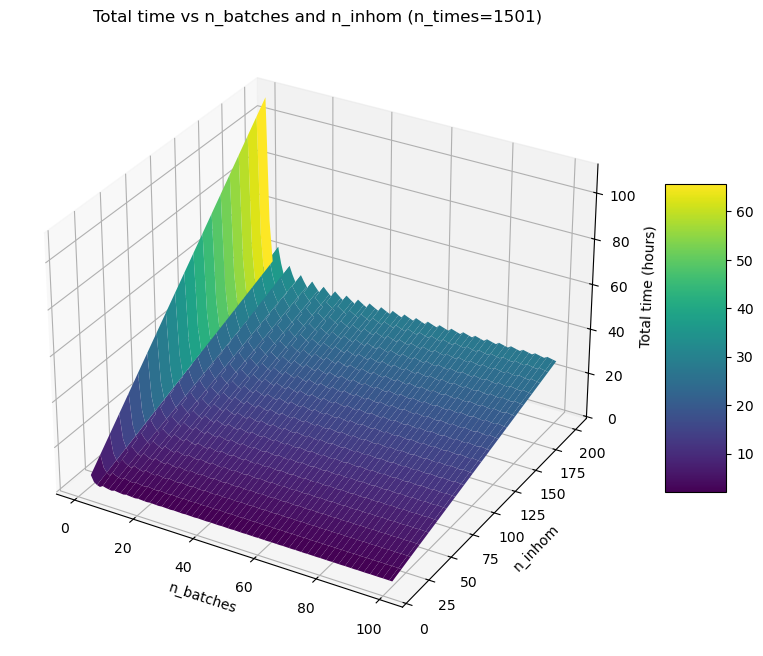

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define ranges
n_inhom_range = np.arange(10, 201, 10)  # 10 to 200, step 10
n_batches_range = np.arange(1, 101, 1)  # 1 to 100
n_times = 1501
sim = test_cases[0][1]

# Initialize Z array
Z = np.zeros((len(n_inhom_range), len(n_batches_range)))

# Compute total time for each combination
for i, n_inhom in enumerate(n_inhom_range):
    combos = n_times * n_inhom
    max_n_batches = min(combos, 1000)
    for j, n_batches in enumerate(n_batches_range):
        if n_batches > max_n_batches:
            Z[i, j] = np.nan  # or skip
            continue
        mem, time_str = estimate_slurm_resources(n_inhom, n_times, n_batches, workers=sim.simulation_config.max_workers, N_dim=sim.system.dimension(), solver=sim.simulation_config.ode_solver, n_atoms=sim.system.n_atoms)
        time_per_batch = parse_time_to_seconds(time_str)
        parallel_groups = math.ceil(n_batches / 4)
        total_time = parallel_groups * time_per_batch
        Z[i, j] = total_time / 3600  # convert to hours

# Create meshgrid
X, Y = np.meshgrid(n_batches_range, n_inhom_range)

# Plot 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('n_batches')
ax.set_ylabel('n_inhom')
ax.set_zlabel('Total time (hours)')
ax.set_title('Total time vs n_batches and n_inhom (n_times=1501)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()